# expiMap

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 05.01.2023
- **Date of Last Modification:** 12.01.2023

- The expiMap source code is available at https://github.com/theislab/scarches.
- The corresponding preprint is "Lotfollahi, M. et al. Biologically informed deep learning to infer gene program activity in single cells. bioRxiv 2022.02.05.479217 (2022) doi:10.1101/2022.02.05.479217".

- The workflow of this notebook follows the tutorial from https://scarches.readthedocs.io/en/latest/expimap_surgery_pipeline_basic.html.
- We use a modified version of the autotalker gene program mask with only target genes as the gene program mask for expimap. The reasons are that it is relevant for cell communication, to improve comparability and since the expiMap method did not work well on this dataset with the reactome gene program used in the above cited tutorial.
- The authors use raw counts as input to expiMap. Therefore, we also use raw counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [10]:
import sys
sys.path.append("../../../autotalker")

In [11]:
import os
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scarches as sca
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [12]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
latent_key = "expimap_latent"
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0 # used for Leiden clustering

### 1.3 Run Notebook Setup

In [13]:
sc.set_figure_params(figsize=(6, 6))

In [14]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [15]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/method_benchmarking/{dataset}/expimap"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

In [16]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Data

In [17]:
# Load Data
adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
adata = adata_original.copy()

# Store raw counts in optimized format in adata.X
adata.layers["counts"] = adata.layers["counts"].tocsr()
adata.X = adata.layers["counts"]

adata.obs["batch"] = "embryo2"

## 3. expiMap Model

In [18]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=False,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [19]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path)

In [20]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [21]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [22]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset", #None,
    combine_overlap_gps=True, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [23]:
# Add the gene program dictionary as binary masks to the adata for model training
# Use only target genes from the Autotalker gene program mask
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key="I",
    gp_sources_mask_key="_",
    gp_names_key="terms",
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns["terms"])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 1 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |█████---------------| 25.0%  - epoch_loss: 287.4379705811 - epoch_recon_loss: 270.9817346191 - epoch_kl_loss: 33.2449222946 - val_loss: 285.4548975627 - val_recon_loss: 269.2427724202 - val_kl_loss: 32.75177065538
ADJUSTED LR
 |█████---------------| 28.7%  - epoch_loss: 286.0618225098 - epoch_recon_loss: 269.5676438904 - epoch_kl_loss: 32.9883576775 - val_loss: 288.1957219442 - val_recon_loss: 272.0872955322 - val_kl_loss: 32.2168585459
ADJUSTED LR
 |██████--------------| 32.0%  - epoch_loss: 286.0607186890 - epoch_recon_loss: 269.5475332642 - epoch_kl_loss: 33.0263727379 - val_loss: 283.9378204346 - va

/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


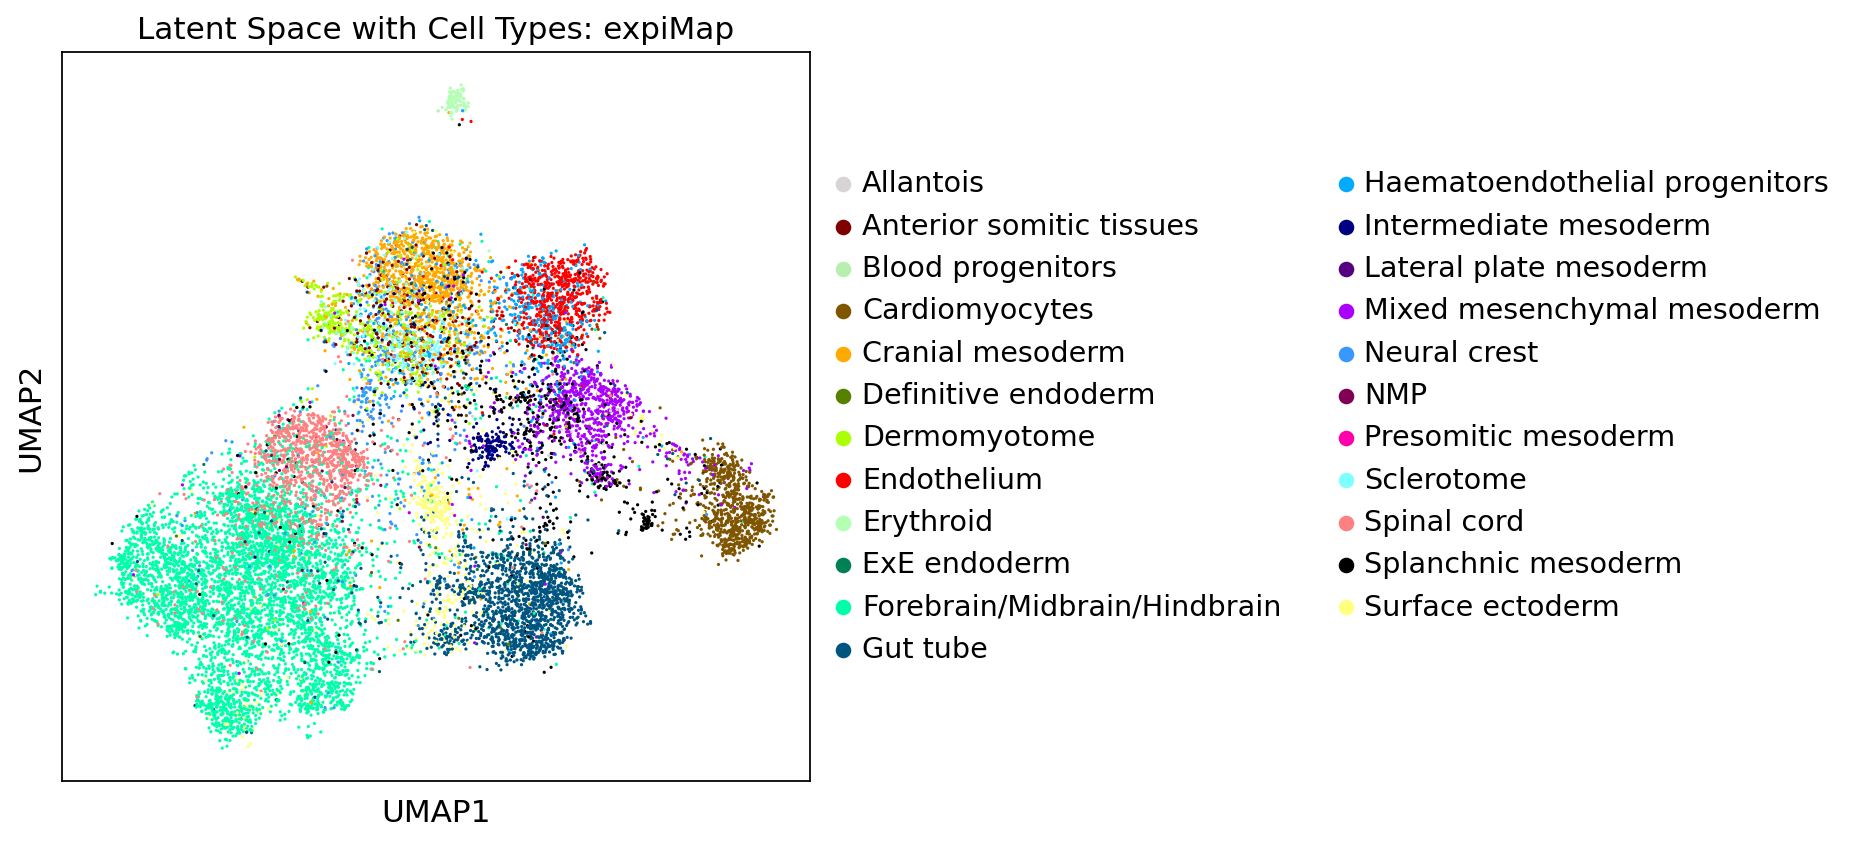

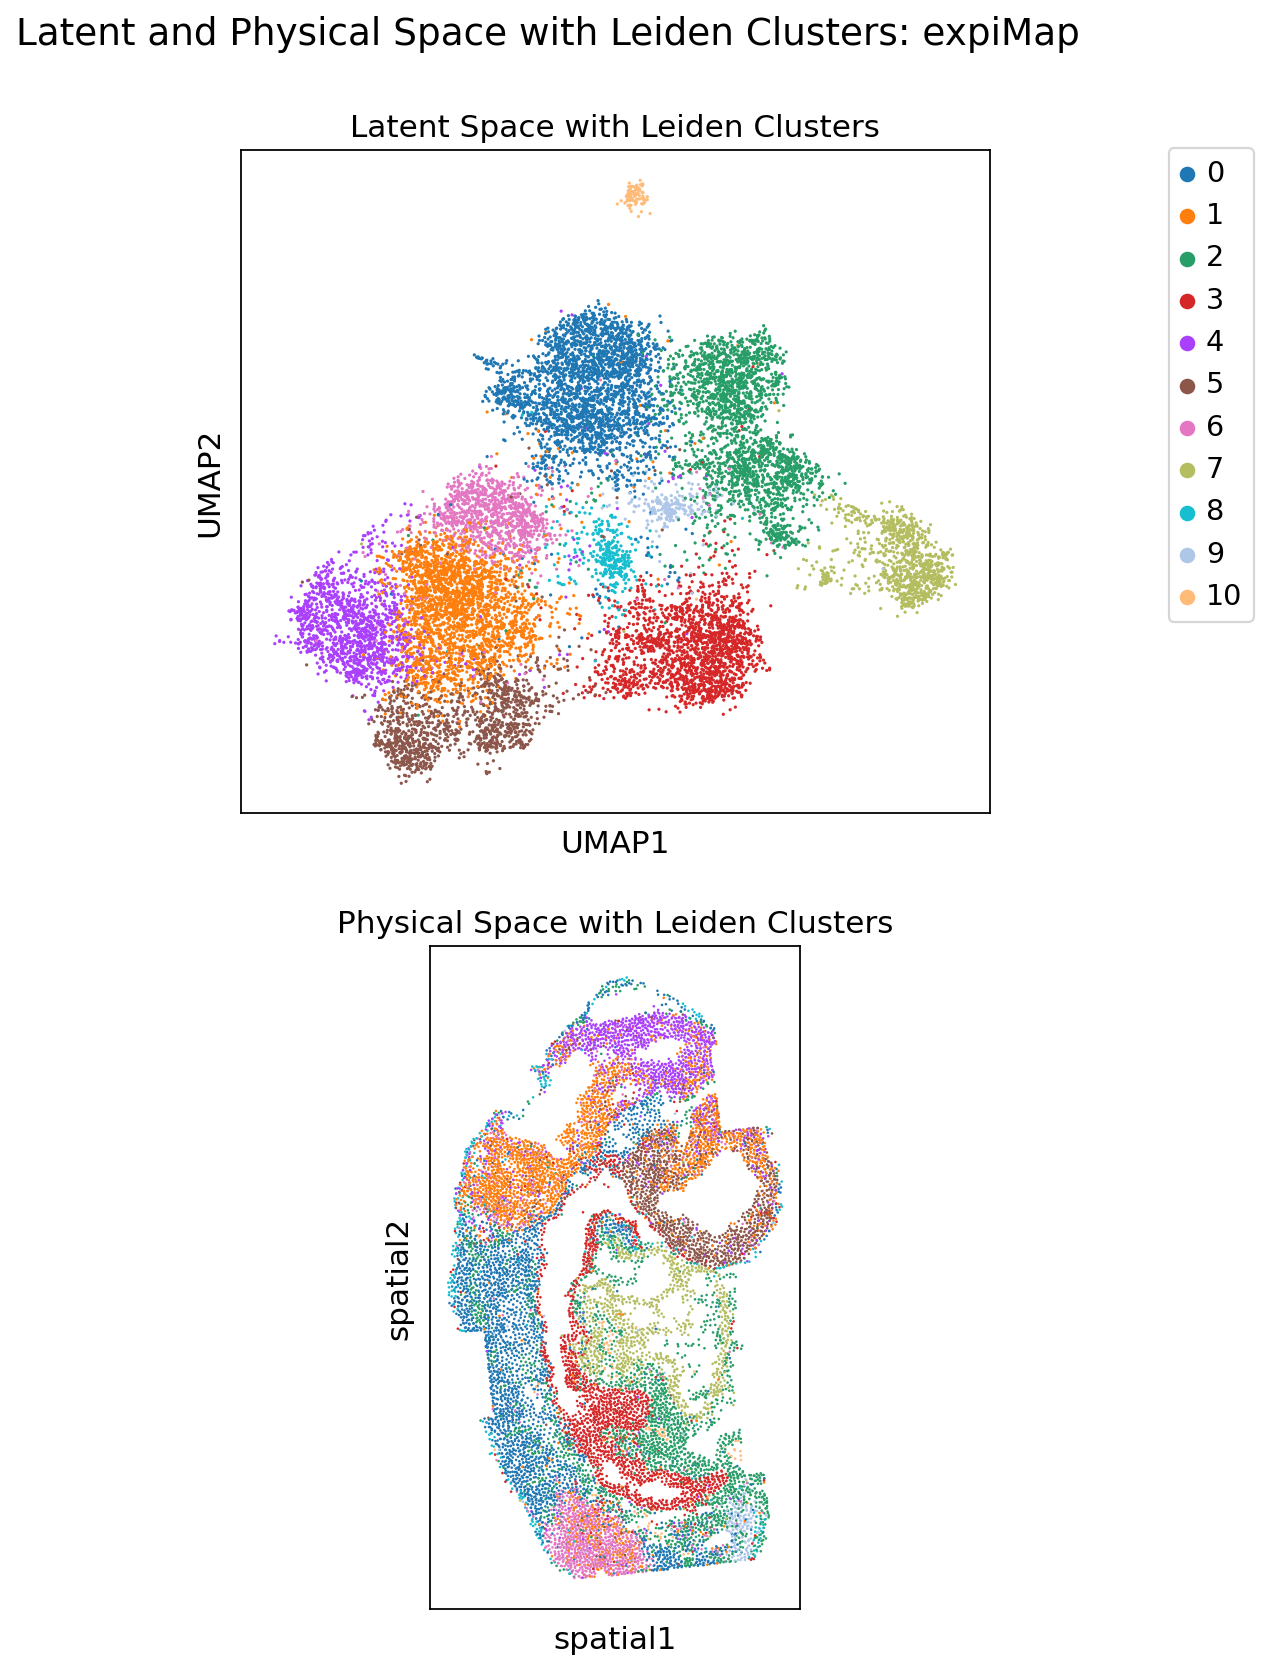


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 1 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 33.0%  - epoch_loss: 285.8097918701 - epoch_recon_loss: 270.1351831055 - epoch_kl_loss: 31.3492184448 - val_loss: 289.2502975464 - val_recon_loss: 274.2581799825 - val_kl_loss: 29.984231789935
ADJUSTED LR
 |███████-------------| 36.8%  - epoch_loss: 283.8416656494 - epoch_recon_loss: 268.1900750732 - epoch_kl_loss: 31.3031824684 - val_loss: 287.8609975179 - val_recon_loss: 272.4197667440 - val_kl_loss: 30.8824712435
ADJUSTED LR
 |████████------------| 40.0%  - epoch_loss: 285.0444830322 - epoch_recon_loss: 269.2869609070 - epoch_kl_loss: 31.5150427437 - val_loss: 285.4155171712 - v

/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


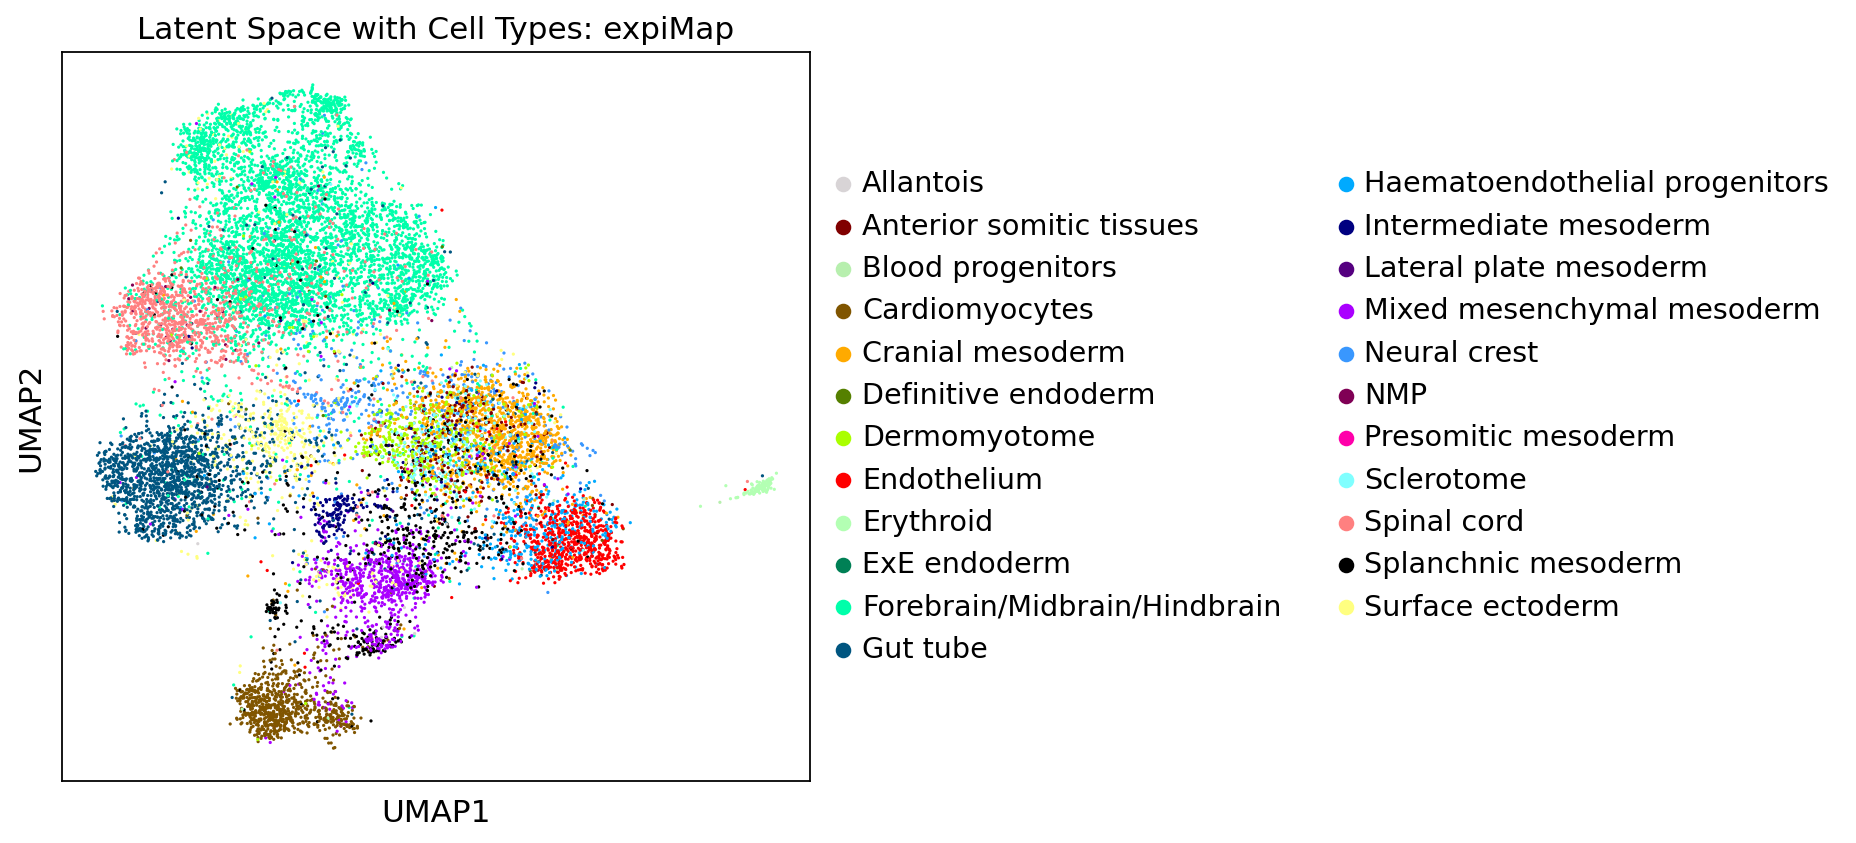

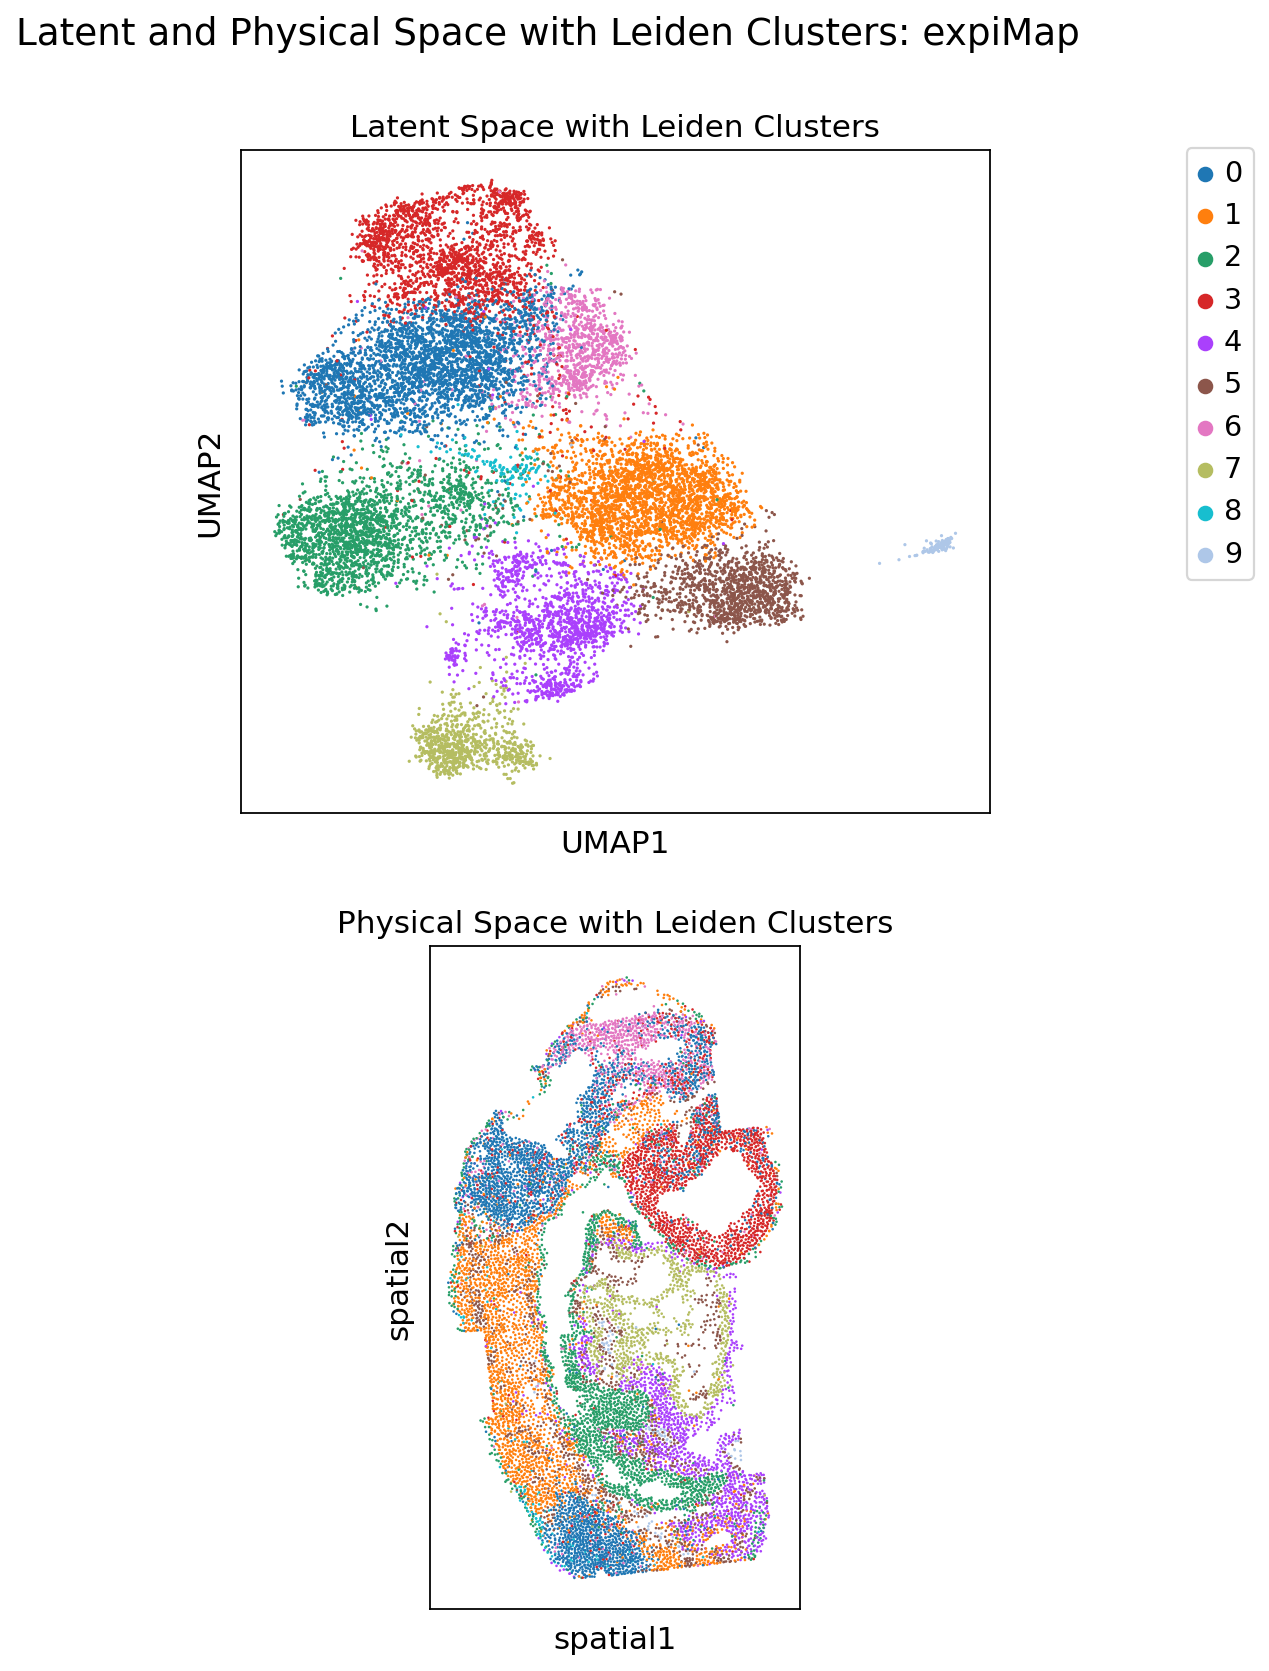


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 1 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |████----------------| 23.0%  - epoch_loss: 283.1466183472 - epoch_recon_loss: 266.6552505493 - epoch_kl_loss: 36.2447663498 - val_loss: 286.6025161743 - val_recon_loss: 270.6630325317 - val_kl_loss: 35.031826019359
ADJUSTED LR
 |██████--------------| 33.5%  - epoch_loss: 284.4443475342 - epoch_recon_loss: 267.5906129456 - epoch_kl_loss: 33.7074668312 - val_loss: 285.0957209269 - val_recon_loss: 268.7869084676 - val_kl_loss: 32.6176184018
ADJUSTED LR
 |████████------------| 40.0%  - epoch_loss: 284.3647482300 - epoch_recon_loss: 267.4373561096 - epoch_kl_loss: 33.8547863579 - val_loss: 288.4968872070 - v

/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


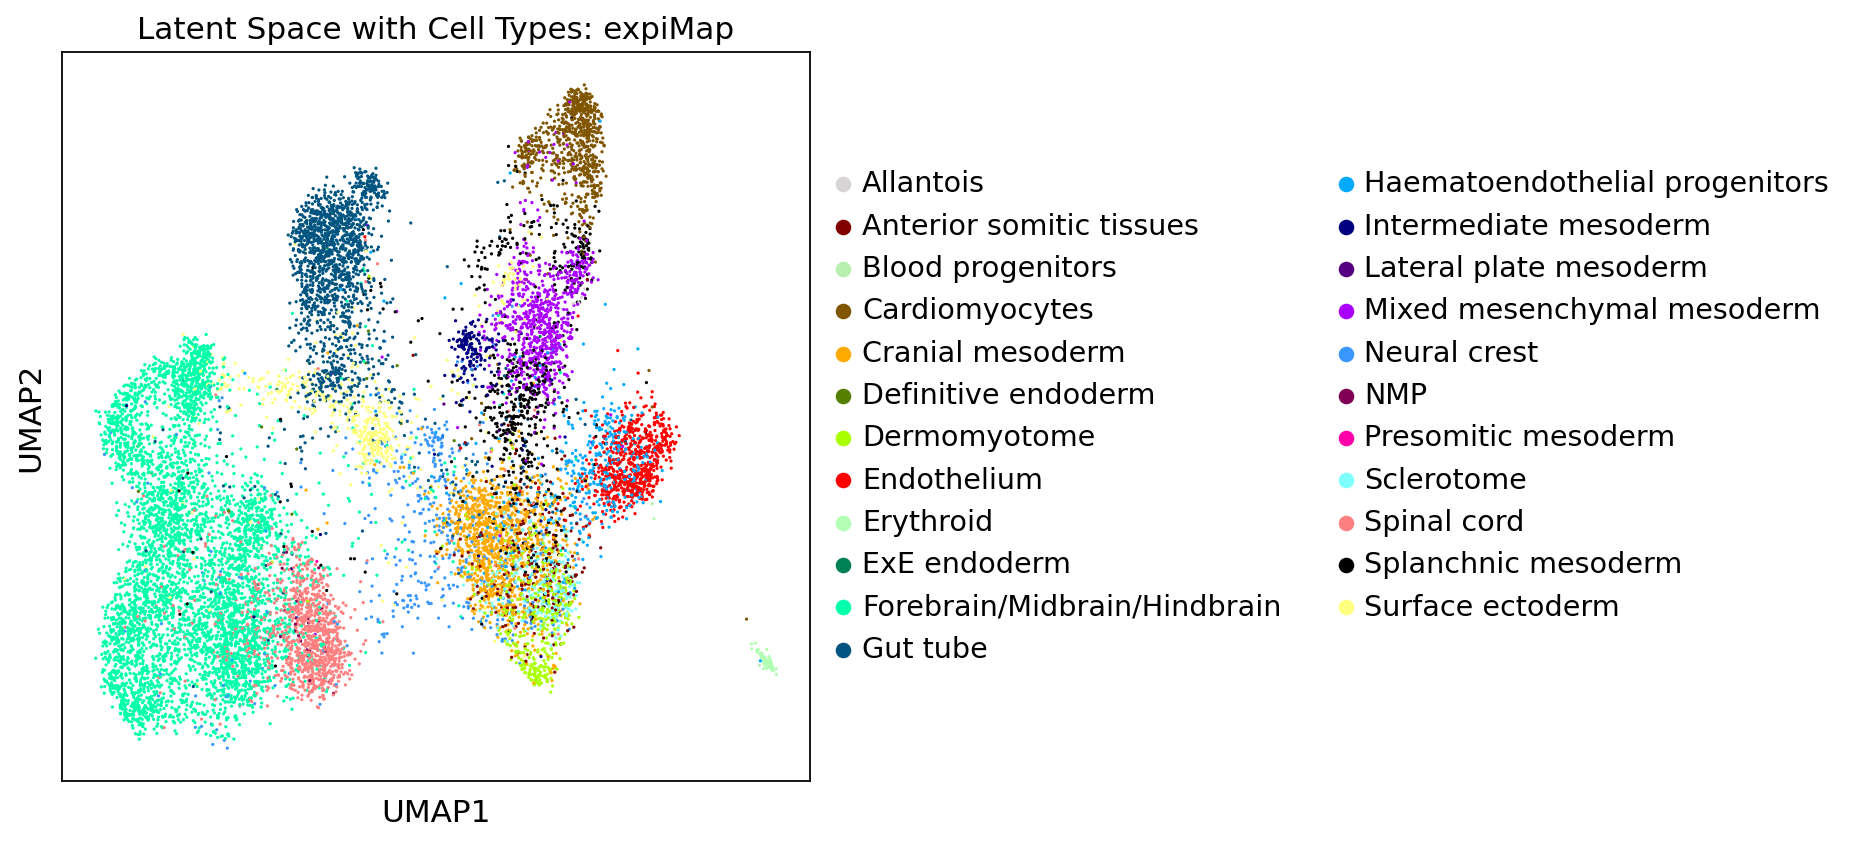

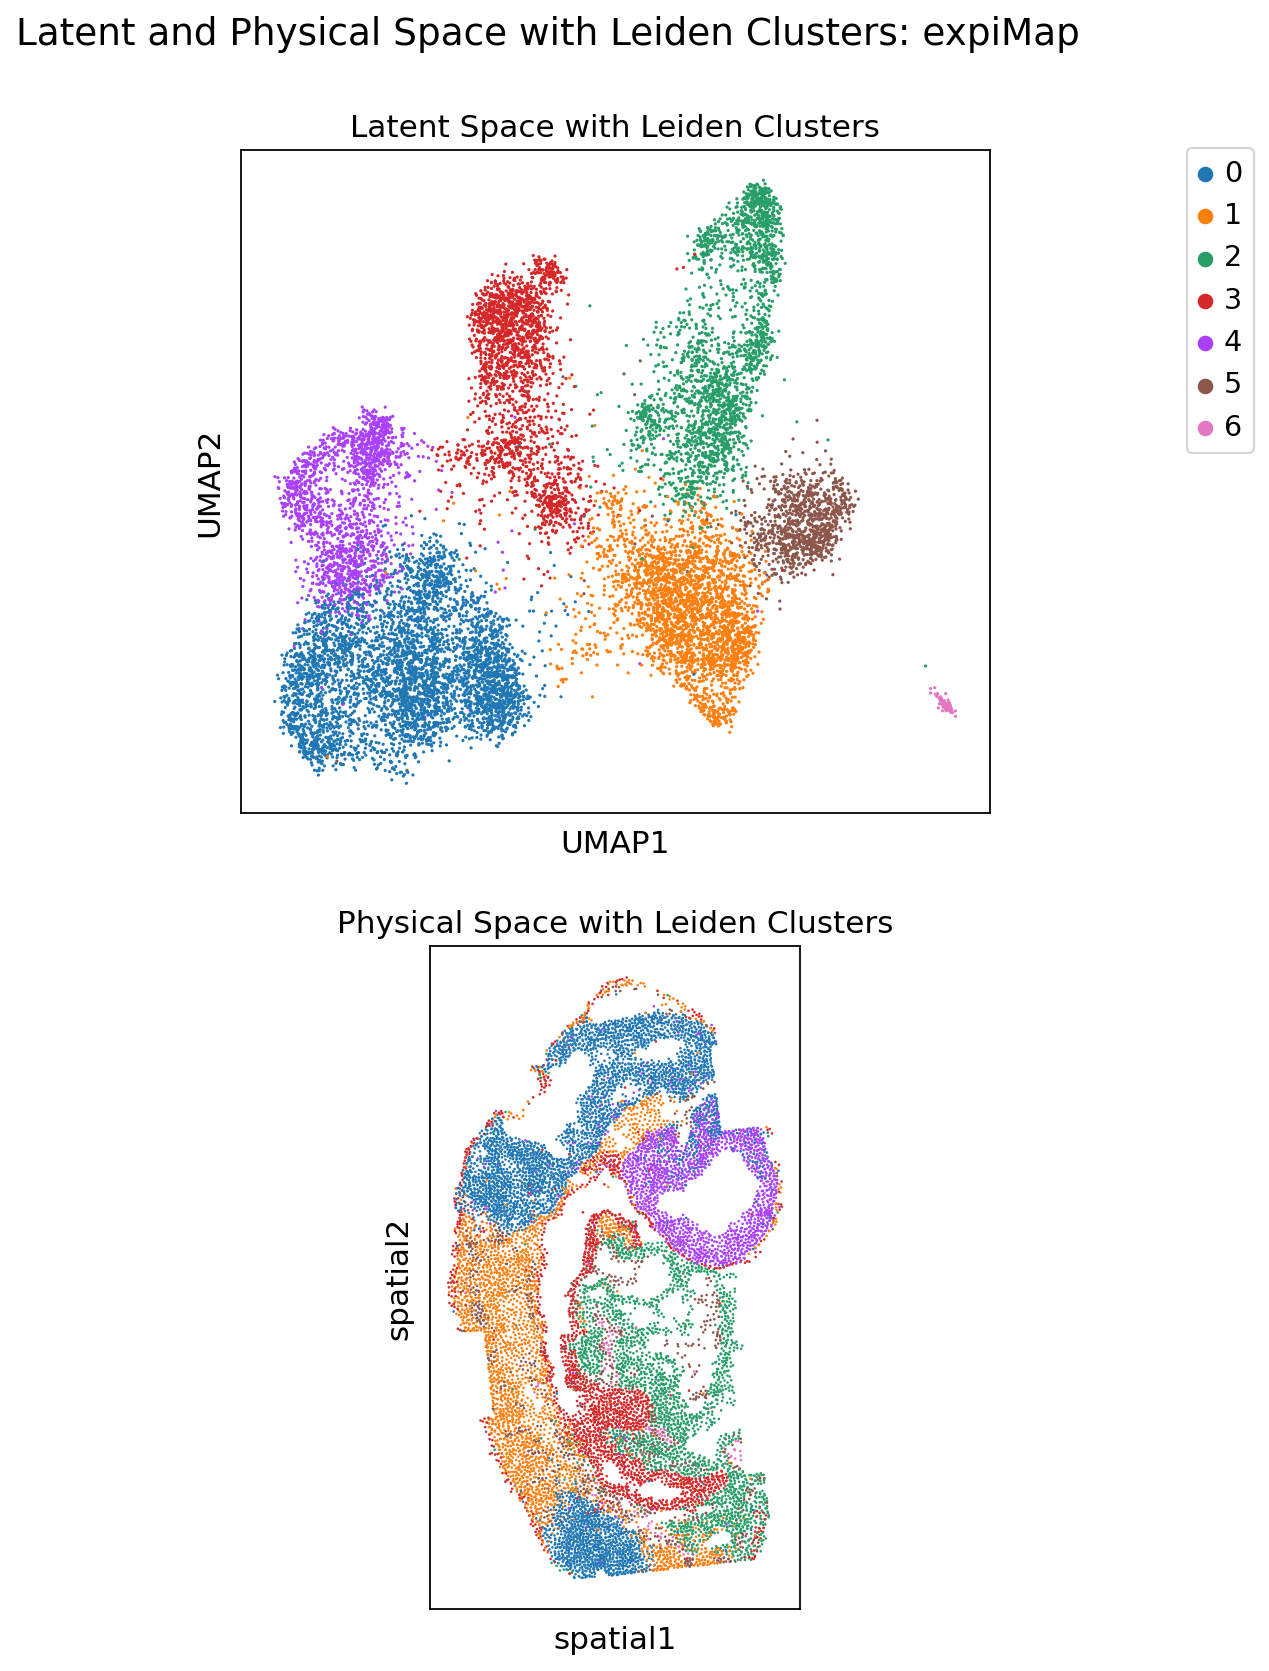


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 1 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 30.8%  - epoch_loss: 285.4626199341 - epoch_recon_loss: 268.8417312622 - epoch_kl_loss: 33.2417755508 - val_loss: 291.3889134725 - val_recon_loss: 274.9410985311 - val_kl_loss: 32.89563401541
ADJUSTED LR
 |██████--------------| 34.0%  - epoch_loss: 282.9475750732 - epoch_recon_loss: 266.3768206787 - epoch_kl_loss: 33.1415069580 - val_loss: 292.3025385539 - val_recon_loss: 275.8762079875 - val_kl_loss: 32.8526606560
ADJUSTED LR
 |███████-------------| 37.2%  - epoch_loss: 285.2496026611 - epoch_recon_loss: 268.5827291870 - epoch_kl_loss: 33.3337451172 - val_loss: 291.4305445353 - va

/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


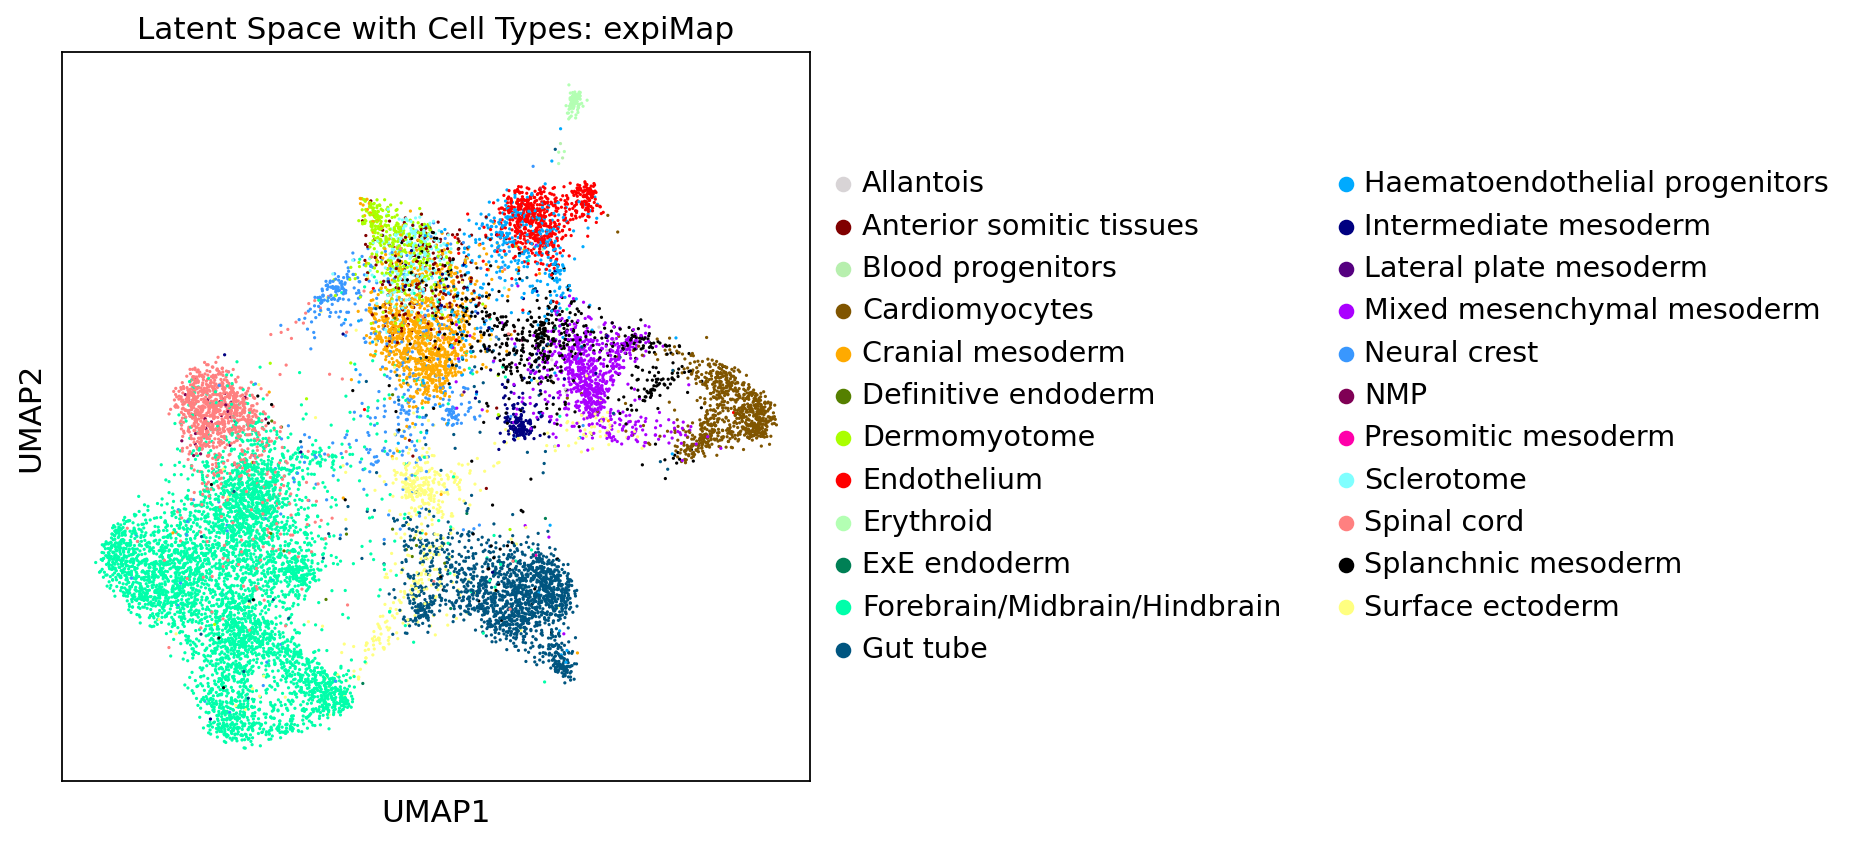

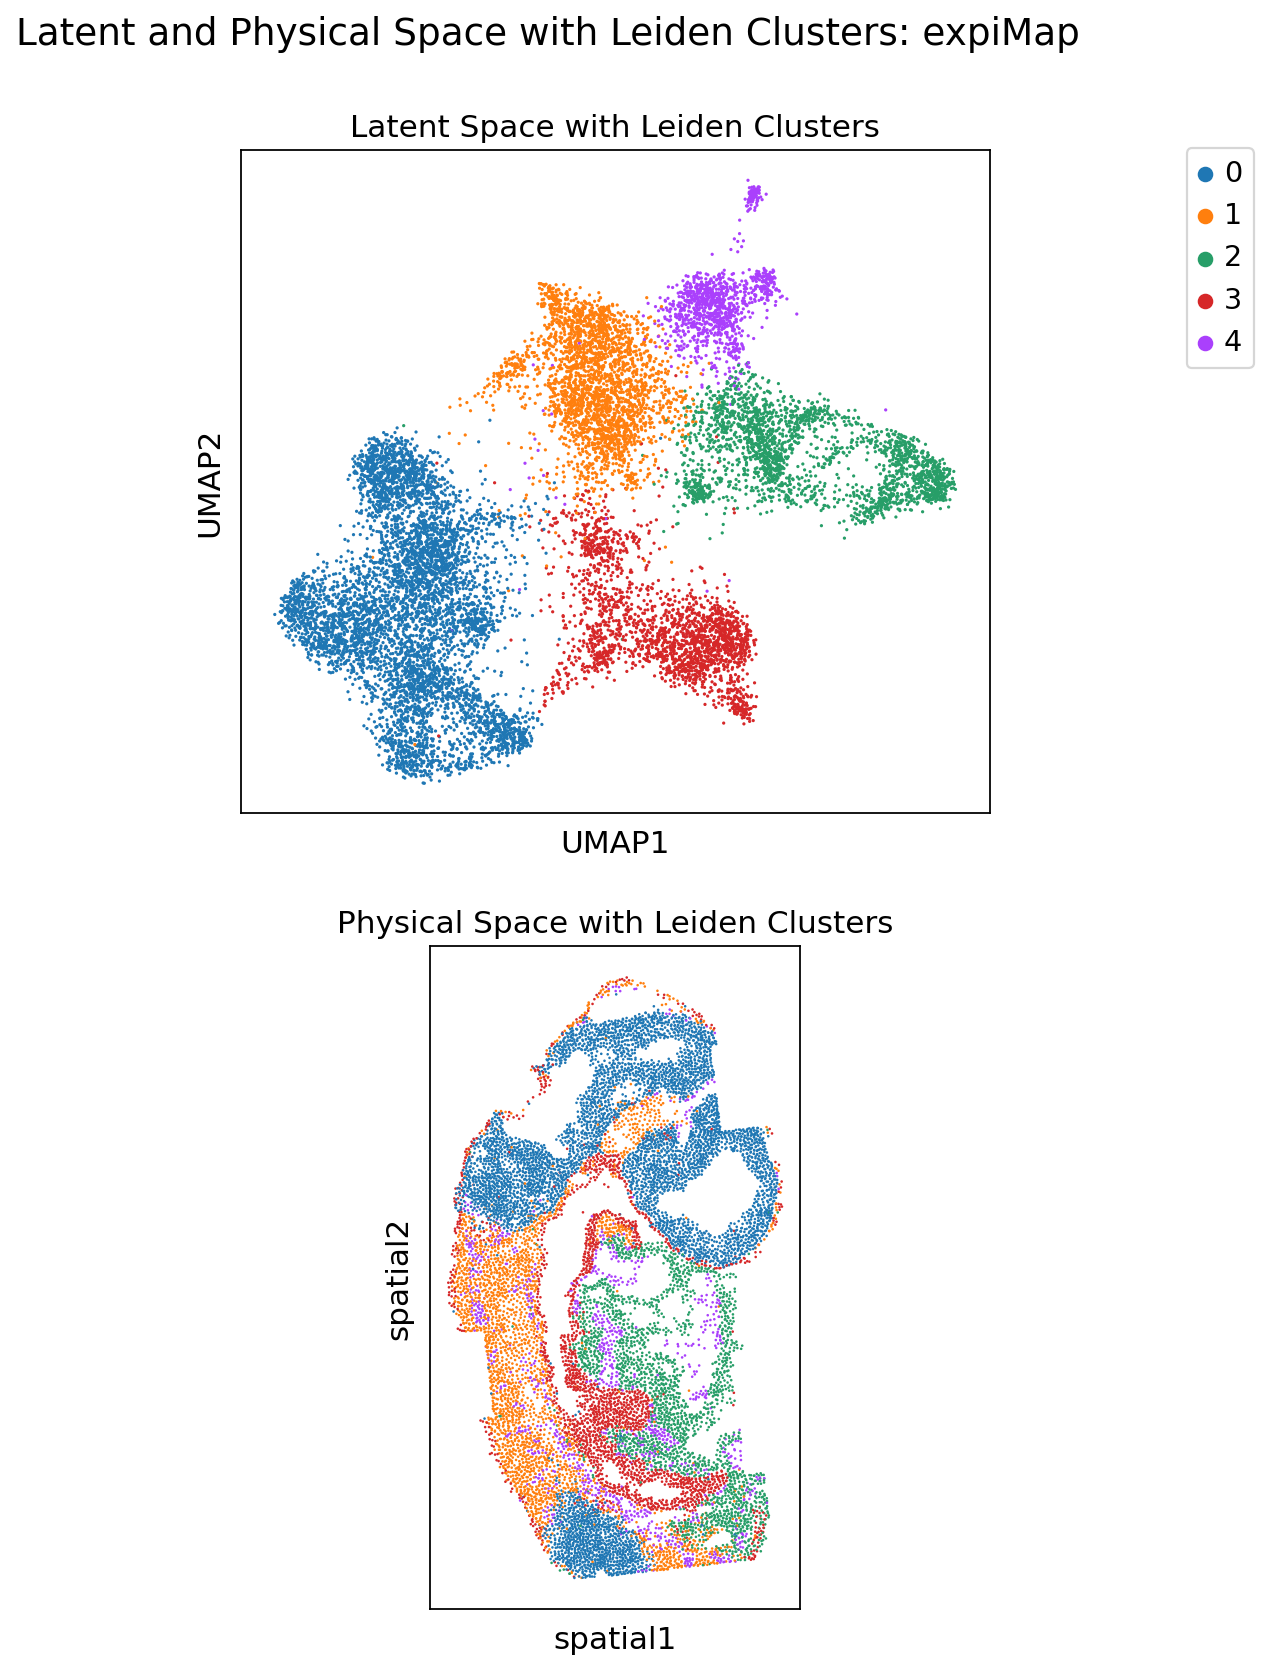


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 1 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |█████---------------| 26.5%  - epoch_loss: 286.4353283691 - epoch_recon_loss: 269.5677589417 - epoch_kl_loss: 33.7351371574 - val_loss: 282.0230534871 - val_recon_loss: 266.2538108826 - val_kl_loss: 31.53848663976
ADJUSTED LR
 |███████-------------| 37.2%  - epoch_loss: 286.6355743408 - epoch_recon_loss: 269.7175247192 - epoch_kl_loss: 33.8360966492 - val_loss: 282.6941553752 - val_recon_loss: 266.4932098389 - val_kl_loss: 32.4018917084
ADJUSTED LR
 |████████------------| 40.5%  - epoch_loss: 286.6264883423 - epoch_recon_loss: 269.7265371704 - epoch_kl_loss: 33.7998995018 - val_loss: 275.8670870463 - va

/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


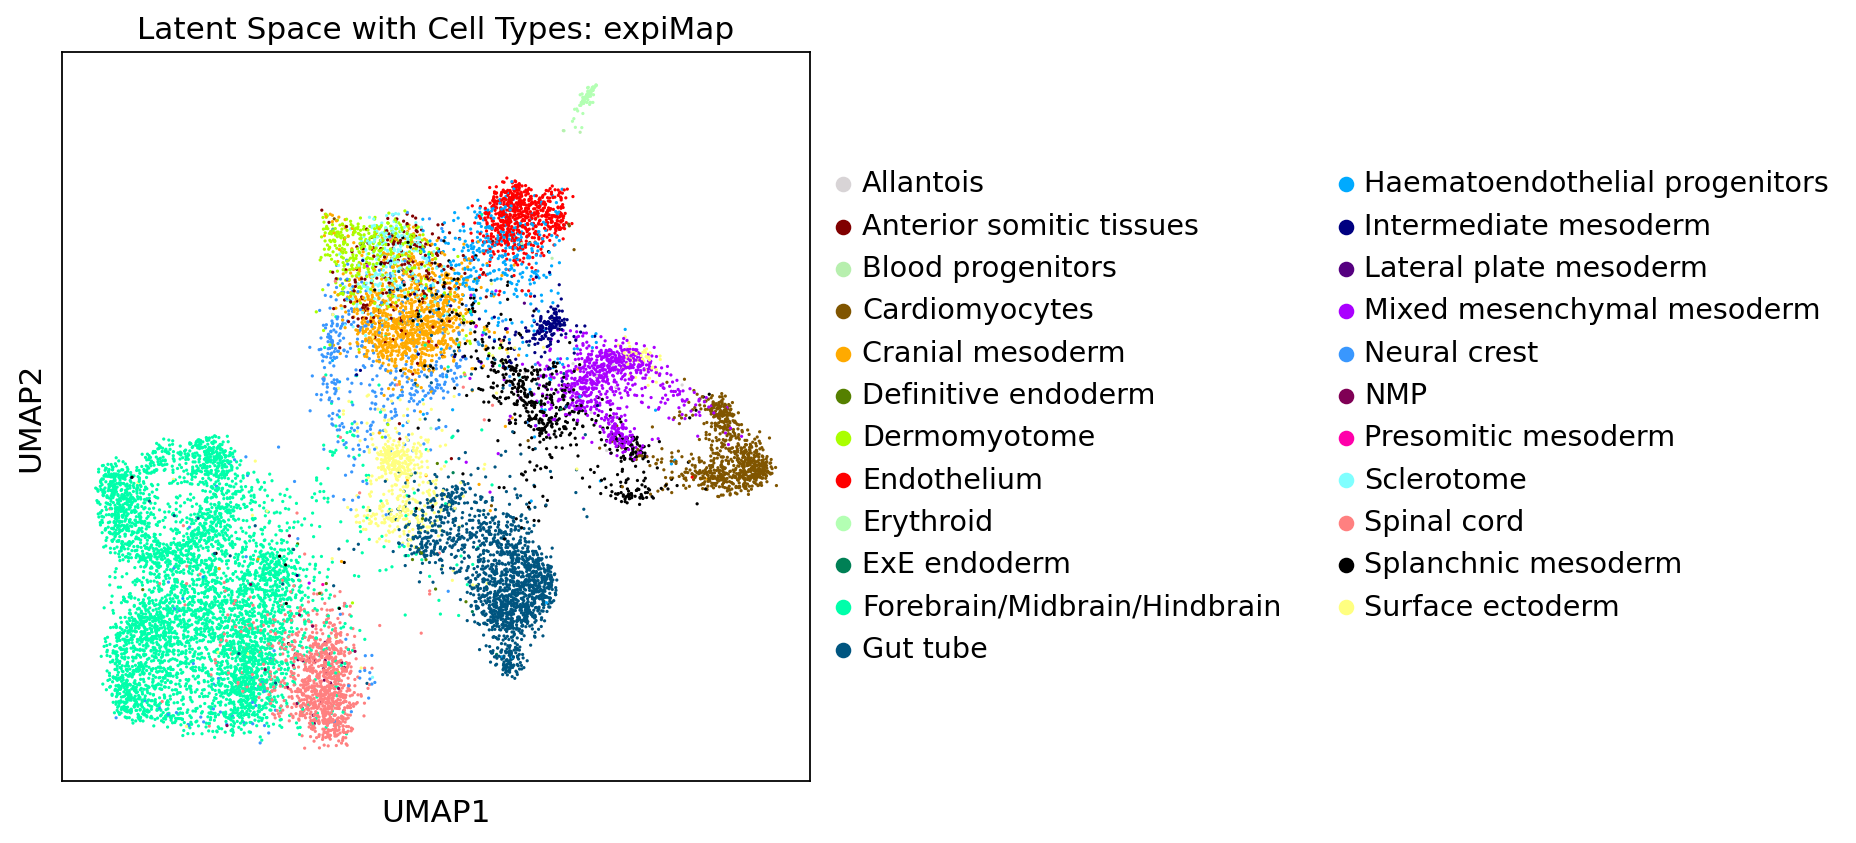

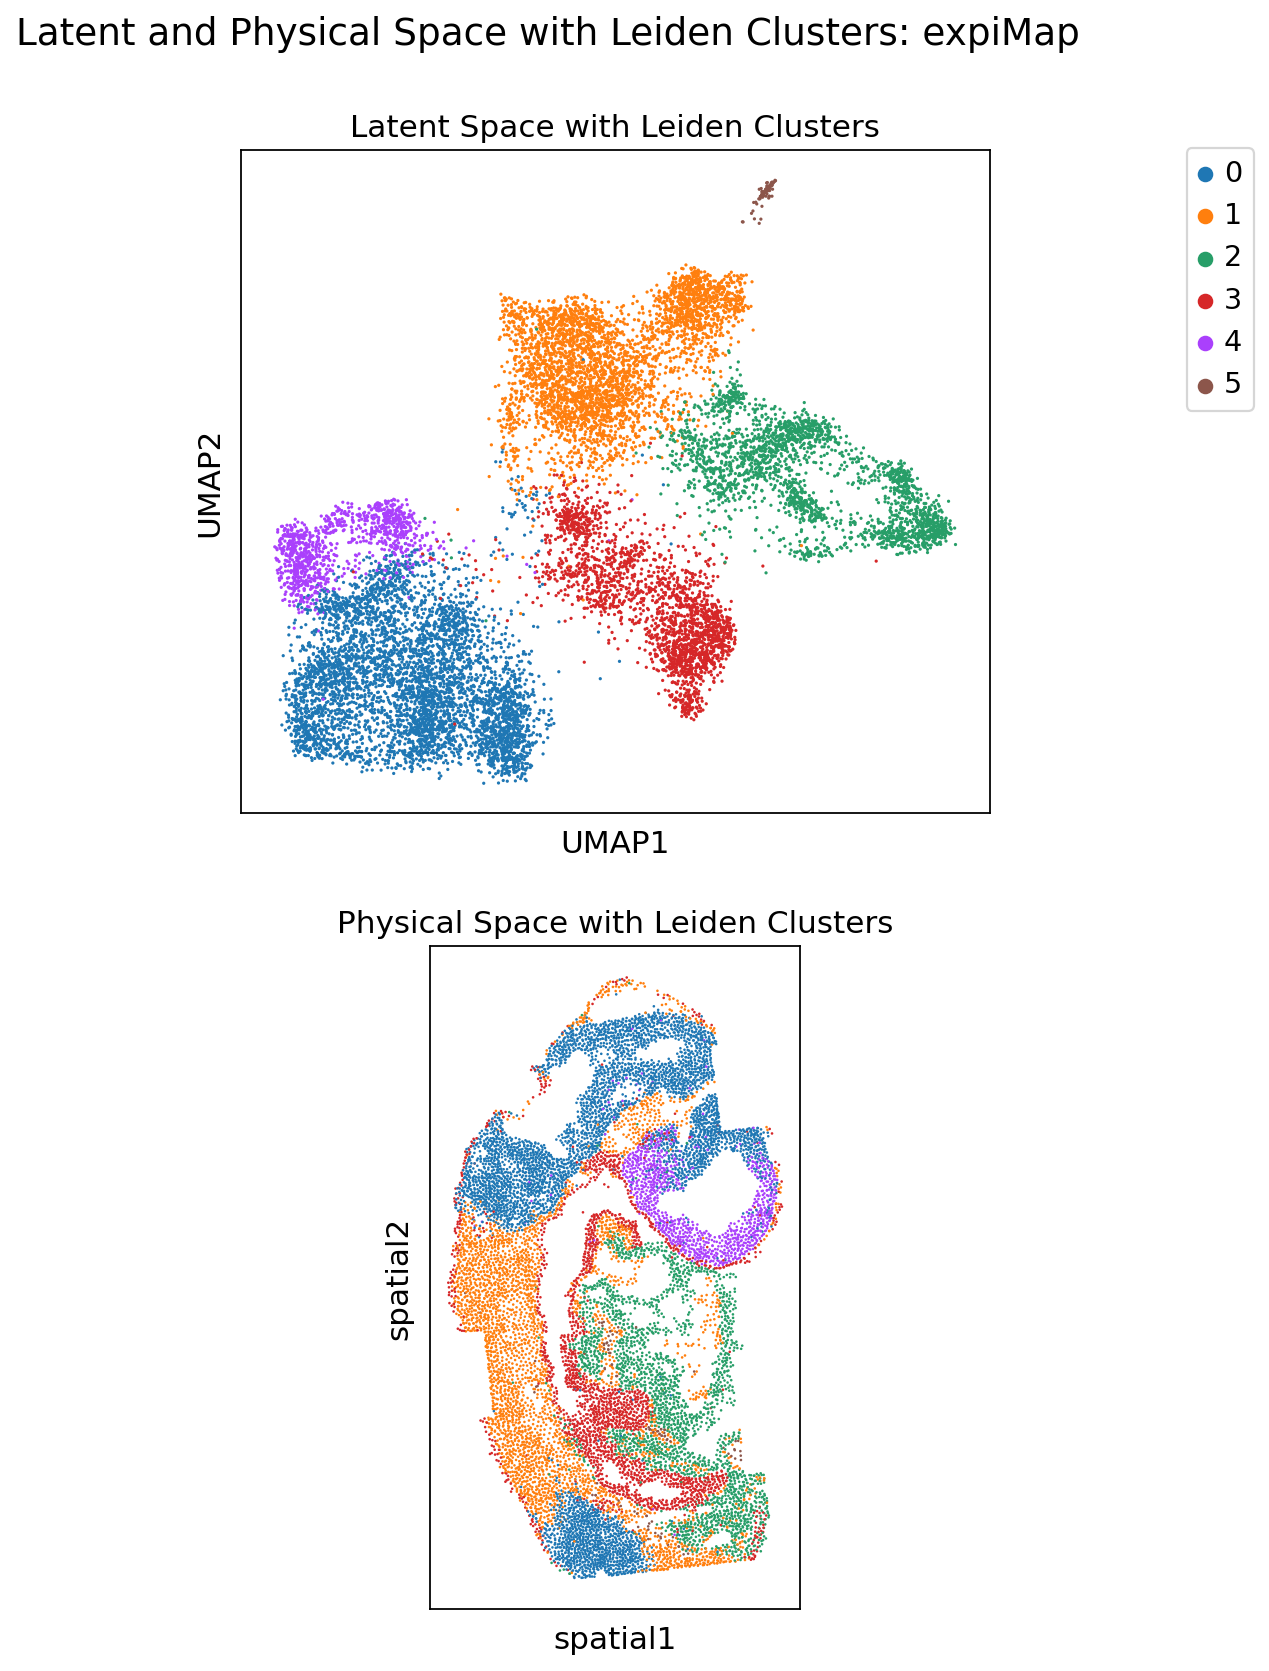


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 351 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 489
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  489 0 0 1 351
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |████----------------| 20.8%  - epoch_loss: 283.0408615112 - epoch_recon_loss: 267.4351927185 - epoch_kl_loss: 38.0626064682 - val_loss: 285.1446126302 - val_recon_loss: 269.7200698853 - val_kl_loss: 37.620837211650
ADJUSTED LR
 |█████---------------| 26.8%  - epoch_loss: 284.3758892822 - epoch_recon_loss: 267.5749714661 - epoch_kl_loss: 33.6018372154 - val_loss: 282.8783874512 - val_recon_loss: 266.5329373678 - val_kl_loss: 32.6909031868
ADJUSTED LR
 |██████--------------| 32.8%  - epoch_loss: 285.5641430664 - epoch_recon_loss: 268.8024185181 - epoch_kl_loss: 33.5234493446 - val_loss: 284.5785903931 - v

In [ ]:
model_seeds = list(range(10))

for run_number, n_neighbors in zip(np.arange(1,11), [4, 4, 8, 8, 12, 12, 16, 16, 20, 20]): # n_neighbors is here only used for the latent neighbor graph since expiMap is not a spatial method
    # Initialize model
    intr_cvae = sca.models.EXPIMAP(adata=adata,
                                   condition_key="batch",
                                   hidden_layer_sizes=[256, 256, 256],
                                   recon_loss="nb")
    
    # Train model
    early_stopping_kwargs = {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 50,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    }
    intr_cvae.train(
        n_epochs=400,
        alpha_epoch_anneal=100,
        alpha=0.7,
        alpha_kl=0.5,
        weight_decay=0.,
        early_stopping_kwargs=early_stopping_kwargs,
        use_early_stopping=True,
        monitor_only_val=False,
        seed=model_seeds[run_number - 1],
    )
    
    # Store latent representation
    adata.obsm[latent_key] = intr_cvae.get_latent(mean=False, only_active=True)
    
    # Use expiMap latent space for UMAP generation
    sc.pp.neighbors(adata, use_rep=latent_key, n_neighbors=n_neighbors)
    sc.tl.umap(adata, min_dist=0.3)
    fig = sc.pl.umap(adata,
                     color=[cell_type_key],
                     title="Latent Space with Cell Types: expiMap",
                     return_fig=True)
    fig.savefig(f"{figure_folder_path}/latent_expimap_cell_types_run_{run_number}_{current_timestamp}.png",
                bbox_inches="tight")
    
    # Compute latent Leiden clustering
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolution,
                 random_state=random_seed,
                 key_added=f"latent_expimap_leiden_{str(leiden_resolution)}")
    
    # Create subplot of latent Leiden cluster annotations in physical and latent space
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
    title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: expiMap")
    sc.pl.umap(adata=adata,
               color=[f"latent_expimap_leiden_{str(leiden_resolution)}"],
               title=f"Latent Space with Leiden Clusters",
               ax=axs[0],
               show=False)
    sc.pl.spatial(adata=adata,
                  color=[f"latent_expimap_leiden_{str(leiden_resolution)}"],
                  spot_size=0.03,
                  title=f"Physical Space with Leiden Clusters",
                  ax=axs[1],
                  show=False)

    # Create and position shared legend
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()

    # Adjust, save and display plot
    plt.subplots_adjust(wspace=0, hspace=0.2)
    fig.savefig(f"{figure_folder_path}/latent_physical_comparison_expimap_leiden_{run_number}_{current_timestamp}.png",
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
    plt.show()
    
    # Store latent representation
    adata_original.obsm[latent_key + f"_run{run_number}"] = intr_cvae.get_latent(mean=False, only_active=True)

    # Store active gene programs
    active_gps_idx = intr_cvae.nonzero_terms()
    adata_original.uns[f"expimap_active_gp_names_run{run_number}"] = adata.uns["terms"][active_gps_idx]
    
    # Store intermediate adata to disk
    adata_original.write(f"{data_folder_path}/{dataset}_expimap.h5ad")
    
# Add sample as observation
adata_original.obs["sample"] = "embryo2"
    
# Store final adata to disk
adata_original.write(f"{data_folder_path}/{dataset}_expimap.h5ad")    